# Pitcher WAR/162 Projection – Multi-Year t → t+1 (Optimized for Pitchers)

This notebook predicts **next-year WAR per 162 games (WAR/162)** for pitchers from
**current-year features** using the multi-year dataset:

`data/Pitchers_2015-2025_byYear_retry.csv`

Design decisions are tuned for **pitchers**:

- Build a **year t → year t+1** panel for all seasons.
- Restrict to pitchers with **meaningful workloads** in both seasons to reduce noise
  (default: `IP_t ≥ 30` and `IP_{t+1} ≥ 30`).
- Drop features that are missing in >60% of rows (e.g., sparse Statcast / bat-tracking fields).
- Two feature configurations:
  - `skill_only`: excludes current-year WAR/WAR_per_162 (pure skill & context).
  - `with_prev_war`: includes current-year WAR and WAR_per_162 (realistic projection setup).
- Models:
  - **ElasticNetCV** (regularized linear regression).
  - **MLPRegressor** (simple NN for tabular data).
- Train on all transitions with `Season ≤ 2023` and hold out `Season == 2024` (predicting 2025).


In [54]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7, 7)

# Define root_mean_squared_error for compatibility with older sklearn versions
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Hyperparameter tuning settings
ALPHA_RANGE = np.logspace(-3, 2, 20)  # Range of alpha values to try
L1_RATIO_RANGE = [0.1, 0.3, 0.5, 0.7, 0.9]  # Range of l1_ratio values to try
MIN_IP_TRAIN = 30  # Minimum IP threshold for training data


## 1. Load pitcher-by-year dataset and compute WAR_per_162

In [55]:
data_path = 'data/Pitchers_2015-2025_byYear_retry.csv'
df = pd.read_csv(data_path)
print('Shape:', df.shape)
print('Columns (first 25):', list(df.columns)[:25])
print('\nSeason value counts:')
print(df['Season'].value_counts().sort_index())

df = df.copy()
df['WAR_per_162'] = (df['WAR'] / df['G'].replace(0, np.nan)) * 162
print('\nSample WAR_per_162 rows:')
print(df[['mlbID', 'Season', 'G', 'WAR', 'WAR_per_162']].head())


Shape: (8968, 76)
Columns (first 25): ['Name', 'Age', '#days', 'Lev', 'Tm', 'G', 'GS', 'W', 'L', 'SV', 'IP', 'H', 'R', 'ER', 'BB', 'SO', 'HR', 'HBP', 'ERA', 'AB', '2B', '3B', 'IBB', 'GDP', 'SF']

Season value counts:
Season
2015    735
2016    742
2017    755
2018    799
2019    831
2020    735
2021    909
2022    871
2023    863
2024    855
2025    873
Name: count, dtype: int64

Sample WAR_per_162 rows:
    mlbID  Season   G   WAR  WAR_per_162
0  430911    2015  33 -0.13    -0.638182
1  472551    2015  62  0.18     0.470323
2  592091    2015  11 -0.18    -2.650909
3  542866    2015  28  0.30     1.735714
4  502264    2015  13 -0.22    -2.741538


## 2. Build year t → year t+1 panel

We construct pairs where:
- Features come from season `t`.
- Target (`WAR_per_162_next`) comes from season `t+1` for the same pitcher.

In [56]:
min_season, max_season = df['Season'].min(), df['Season'].max()
print('Seasons span:', min_season, 'to', max_season)

# t side: all but last season
df_t = df[df['Season'] < max_season].copy()

# t+1 target side
df_target = df[['mlbID', 'Season', 'WAR_per_162', 'IP']].copy()
df_target = df_target.rename(columns={
    'Season': 'Season_next',
    'WAR_per_162': 'WAR_per_162_next',
    'IP': 'IP_next',
})
df_target['Season'] = df_target['Season_next'] - 1

panel = df_t.merge(
    df_target[['mlbID', 'Season', 'Season_next', 'WAR_per_162_next', 'IP_next']],
    on=['mlbID', 'Season'],
    how='inner'
)

print('Panel shape (t -> t+1 pairs):', panel.shape)
print('\nPairs by t (Season):')
print(panel['Season'].value_counts().sort_index())
print('\nPairs by t+1 (Season_next):')
print(panel['Season_next'].value_counts().sort_index())

# Drop missing targets
panel = panel.dropna(subset=['WAR_per_162', 'WAR_per_162_next'])
print('\nPanel after dropping missing WAR_per_162:', panel.shape)


Seasons span: 2015 to 2025
Panel shape (t -> t+1 pairs): (5788, 80)

Pairs by t (Season):
Season
2015    526
2016    539
2017    557
2018    589
2019    549
2020    586
2021    612
2022    604
2023    611
2024    615
Name: count, dtype: int64

Pairs by t+1 (Season_next):
Season_next
2016    526
2017    539
2018    557
2019    589
2020    549
2021    586
2022    612
2023    604
2024    611
2025    615
Name: count, dtype: int64

Panel after dropping missing WAR_per_162: (5174, 80)


## 3. Filter to pitchers with meaningful workloads

Next-year WAR is extremely noisy for tiny samples and cups of coffee.
We restrict to pitchers who have **at least a minimum IP** in both t and t+1.

Default:
- `MIN_IP_T = 30`
- `MIN_IP_TP1 = 30`

You can relax or tighten these thresholds depending on your use case.

In [57]:
MIN_IP_T = 30.0     # minimum IP in season t
MIN_IP_TP1 = 30.0   # minimum IP in season t+1

workload_mask = (panel['IP'] >= MIN_IP_T) & (panel['IP_next'] >= MIN_IP_TP1)
panel_w = panel[workload_mask].copy()

print('Panel (workload-filtered) shape:', panel_w.shape)
print('\nWorkload-filtered pairs by t (Season):')
print(panel_w['Season'].value_counts().sort_index())

# Correlation of WAR_per_162_t vs WAR_per_162_{t+1} after filter (sanity upper bound)
corr = panel_w[['WAR_per_162', 'WAR_per_162_next']].corr().iloc[0, 1]
print(f"Correlation WAR_per_162_t vs WAR_per_162_t+1 (filtered): {corr:.3f}")


Panel (workload-filtered) shape: (2527, 80)

Workload-filtered pairs by t (Season):
Season
2015    282
2016    288
2017    290
2018    278
2019    116
2020    126
2021    281
2022    282
2023    292
2024    292
Name: count, dtype: int64
Correlation WAR_per_162_t vs WAR_per_162_t+1 (filtered): 0.374


## 4. Define numeric feature columns and drop highly missing features

We start from all numeric columns, excluding:
- Identifiers and year markers: `mlbID`, `Season`, `Season_next`.
- Target: `WAR_per_162_next`.

Then we drop any feature with >60% missing values in the workload-filtered panel
to avoid letting extremely sparse Statcast/bat-tracking features dominate.

In [58]:
# Identify advanced metrics columns (Statcast/expected stats, similar to bat-tracking in hitters)
# These are typically only available from 2023-2025
advanced_metrics = []
advanced_metric_keywords = [
    'avg_hit', 'max_hit_speed', 'ev50', 'ev95', 'barrels', 'brl_',
    'est_ba', 'est_slg', 'est_woba', 'xera', 'anglesweetspot',
    'max_distance', 'avg_distance', 'avg_hr_distance', 'fbld', 'gb'
]

numeric_cols = panel_w.select_dtypes(include=[np.number]).columns.tolist()
for c in numeric_cols:
    if any(keyword in c.lower() for keyword in advanced_metric_keywords):
        advanced_metrics.append(c)

advanced_metrics = sorted(set(advanced_metrics))
advanced_metrics = [c for c in advanced_metrics if pd.api.types.is_numeric_dtype(panel_w[c])]
print('Detected advanced metrics columns:', len(advanced_metrics))
print(advanced_metrics)

# Identify numeric columns for base features
exclude_base = {'mlbID', 'Season', 'Season_next', 'WAR_per_162_next'}
base_feature_cols = [c for c in numeric_cols if c not in exclude_base]
print('\nInitial numeric feature count (incl current-year WAR):', len(base_feature_cols))

# Drop features with >60% missingness
missing_frac = panel_w[base_feature_cols].isna().mean()
too_sparse = missing_frac[missing_frac > 0.60].index.tolist()
print('Features with >60% missingness:', len(too_sparse))

base_feature_cols = [c for c in base_feature_cols if c not in too_sparse]
print('Final feature count after dropping sparse columns:', len(base_feature_cols))
print('Example features:', base_feature_cols[:25])


Detected advanced metrics columns: 24
['GB/FB', 'anglesweetspotpercent', 'avg_distance', 'avg_hit_angle', 'avg_hit_speed', 'avg_hr_distance', 'barrels', 'brl_pa', 'brl_percent', 'era_minus_xera_diff', 'est_ba', 'est_ba_minus_ba_diff', 'est_slg', 'est_slg_minus_slg_diff', 'est_woba', 'est_woba_minus_woba_diff', 'ev50', 'ev95percent', 'ev95plus', 'fbld', 'gb', 'max_distance', 'max_hit_speed', 'xera']

Initial numeric feature count (incl current-year WAR): 71
Features with >60% missingness: 1
Final feature count after dropping sparse columns: 70
Example features: ['Age', '#days', 'G', 'GS', 'W', 'L', 'IP', 'H', 'R', 'ER', 'BB', 'SO', 'HR', 'HBP', 'ERA', 'AB', '2B', '3B', 'IBB', 'GDP', 'SF', 'SB', 'CS', 'PO', 'BF']


## 5. Train/test split (multi-year)

- **Train**: all transitions with `Season ≤ 2023` (predicting up through 2024).
- **Test**: transitions with `Season == 2024` (predicting 2025).

In [59]:
# Advanced metrics backfilling (same strategy as hitters)
panel_backfilled = panel_w.copy()

if advanced_metrics:
    print("Step 1: Computing pitcher-level advanced metrics means from 2023-2025...")
    
    # Get advanced metrics data from 2023-2025 (where it exists)
    adv_data_available = panel_backfilled[panel_backfilled['Season'] >= 2023].copy()
    
    # Compute per-pitcher means from 2023-2025
    pitcher_adv_means = adv_data_available.groupby('mlbID')[advanced_metrics].mean()
    
    print(f"  Pitchers with advanced metrics data (2023-2025): {len(pitcher_adv_means)}")
    
    print("Step 2: Backfilling earlier years with pitcher means...")
    
    # For each pitcher, fill missing advanced metrics values with their 2023-2025 mean
    for pitcher_id in pitcher_adv_means.index:
        pitcher_mask = panel_backfilled['mlbID'] == pitcher_id
        for c in advanced_metrics:
            panel_backfilled.loc[pitcher_mask, c] = panel_backfilled.loc[pitcher_mask, c].fillna(
                pitcher_adv_means.loc[pitcher_id, c]
            )
    
    print("Step 3: Setting missing values to zero for pitchers without advanced metrics data...")
    
    # For pitchers without advanced metrics data, use zero
    for c in advanced_metrics:
        panel_backfilled[c] = panel_backfilled[c].fillna(0)
    
    print(f"  Final dataset: {len(panel_backfilled)} rows (all pitchers kept)")

# Train/test split
train_panel = panel_backfilled[panel_backfilled['Season'] <= 2023].copy()
test_panel = panel_backfilled[panel_backfilled['Season'] == 2024].copy()

print(f'\nTrain panel shape: {train_panel.shape}')
print(f'Test panel shape: {test_panel.shape}')


Step 1: Computing pitcher-level advanced metrics means from 2023-2025...
  Pitchers with advanced metrics data (2023-2025): 388
Step 2: Backfilling earlier years with pitcher means...
Step 3: Setting missing values to zero for pitchers without advanced metrics data...
  Final dataset: 2527 rows (all pitchers kept)

Train panel shape: (2235, 80)
Test panel shape: (292, 80)


## 6. Helper: run one experiment (feature_mode + models)

We support two feature modes:
- `skill_only`: drop current-year `WAR` and `WAR_per_162` from features.
- `with_prev_war`: keep them as features (captures persistence in true talent & usage).


In [60]:
def run_experiment(train_panel, test_panel, base_feature_cols, feature_mode='skill_only', random_state=42):
    # Start from base features
    feature_cols = base_feature_cols.copy()

    if feature_mode == 'skill_only':
        feature_cols = [c for c in feature_cols if c not in {'WAR', 'WAR_per_162'}]
    elif feature_mode == 'with_prev_war':
        # Keep WAR and WAR_per_162 as features
        pass
    else:
        raise ValueError(f'Unknown feature_mode: {feature_mode}')

    # Drop any rows with missing target just in case
    train_subset = train_panel.dropna(subset=['WAR_per_162_next']).copy()
    test_subset = test_panel.dropna(subset=['WAR_per_162_next']).copy()

    X_train = train_subset[feature_cols].values
    y_train = train_subset['WAR_per_162_next'].values
    X_test = test_subset[feature_cols].values
    y_test = test_subset['WAR_per_162_next'].values

    # Impute + scale
    imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler()

    X_train_imp = imputer.fit_transform(X_train)
    X_test_imp = imputer.transform(X_test)

    X_train_scaled = scaler.fit_transform(X_train_imp)
    X_test_scaled = scaler.transform(X_test_imp)

    # ElasticNetCV: automatically tunes alpha and l1_ratio via cross-validation
    elastic_cv = ElasticNetCV(
        l1_ratio=L1_RATIO_RANGE,
        alphas=ALPHA_RANGE,
        cv=5,
        random_state=random_state,
        max_iter=2000,
        n_jobs=-1
    )
    elastic_cv.fit(X_train_scaled, y_train)
    y_train_pred = elastic_cv.predict(X_train_scaled)
    y_test_pred = elastic_cv.predict(X_test_scaled)

    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    return {
        'feature_mode': feature_mode,
        'n_train': len(y_train),
        'n_test': len(y_test),
        'feature_count': len(feature_cols),
        'feature_names': feature_cols,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'alpha': elastic_cv.alpha_,  # Tuned alpha from CV
        'l1_ratio': elastic_cv.l1_ratio_,  # Tuned l1_ratio from CV
        'model': elastic_cv,
        'imputer': imputer,
        'scaler': scaler,
        'y_test': y_test,
        'y_test_pred': y_test_pred,
    }


## 7. Run experiments for `skill_only` and `with_prev_war`

We run both feature configurations and compare test RMSE / R².

In [61]:
feature_modes = ['skill_only', 'with_prev_war']

print(f"Training filter: >= {MIN_IP_TRAIN} IP")
print(f"Model: ElasticNetCV (tuning alpha and l1_ratio via 5-fold CV)")
print(f"  Alpha range: {ALPHA_RANGE[0]:.3f} to {ALPHA_RANGE[-1]:.3f} ({len(ALPHA_RANGE)} values)")
print(f"  L1 ratio range: {L1_RATIO_RANGE}")
print("="*80)

all_results = []

for fm in feature_modes:
    print(f"\n=== Running experiment: feature_mode={fm} ===")
    res = run_experiment(train_panel, test_panel, base_feature_cols, feature_mode=fm, random_state=42)
    all_results.append(res)
    print(f"  Train: n={res['n_train']}, R²={res['train_r2']:.3f}, RMSE={res['train_rmse']:.3f}")
    print(f"  Test:  n={res['n_test']}, R²={res['test_r2']:.3f}, RMSE={res['test_rmse']:.3f}")
    print(f"  Tuned: alpha={res['alpha']:.4f}, l1_ratio={res['l1_ratio']:.3f}")

summary_rows = []
for r in all_results:
    summary_rows.append({
        'feature_mode': r['feature_mode'],
        'n_train': r['n_train'],
        'n_test': r['n_test'],
        'feature_count': r['feature_count'],
        'test_rmse': r['test_rmse'],
        'test_r2': r['test_r2'],
        'alpha': r['alpha'],
        'l1_ratio': r['l1_ratio'],
    })

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(by='test_r2', ascending=False)
summary_df


Training filter: >= 30 IP
Model: ElasticNetCV (tuning alpha and l1_ratio via 5-fold CV)
  Alpha range: 0.001 to 100.000 (20 values)
  L1 ratio range: [0.1, 0.3, 0.5, 0.7, 0.9]

=== Running experiment: feature_mode=skill_only ===


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145.90075690204685, tolerance: 17.784613566986913
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.82690567235113, tolerance: 17.784613566986913
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183.57228485806263, tolerance: 17.784613566986913
  model = cd_fast.enet_coo

  Train: n=2235, R²=0.377, RMSE=7.756
  Test:  n=292, R²=0.296, RMSE=7.863
  Tuned: alpha=0.1274, l1_ratio=0.700

=== Running experiment: feature_mode=with_prev_war ===


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20607.30093043692, tolerance: 17.70914386573619
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20135.583290311268, tolerance: 17.70914386573619
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5909.5598116061665, tolerance: 14.786062881560234
  model = cd_fast.enet_coord

  Train: n=2235, R²=0.379, RMSE=7.738
  Test:  n=292, R²=0.316, RMSE=7.751
  Tuned: alpha=0.1274, l1_ratio=0.500


,feature_mode,n_train,n_test,feature_count,test_rmse,test_r2,alpha,l1_ratio
1,with_prev_war,2235,292,70,7.751296,0.315973,0.127427,0.5
0,skill_only,2235,292,68,7.862562,0.296194,0.127427,0.7


## 8. Inspect best configuration and its features

We pick the configuration with the highest NN test R² and print its feature names.

In [62]:
best_idx = int(np.argmax([r['test_r2'] for r in all_results]))
best_res = all_results[best_idx]

print('Best config:')
print(' feature_mode :', best_res['feature_mode'])
print(' test_r2      :', best_res['test_r2'])
print(' test_rmse    :', best_res['test_rmse'])
print(' n_train      :', best_res['n_train'])
print(' n_test       :', best_res['n_test'])
print(' alpha        :', f"{best_res['alpha']:.4f} (tuned)")
print(' l1_ratio     :', f"{best_res['l1_ratio']:.3f} (tuned)")

print('\nFeatures used (best model):')
print(best_res['feature_names'])


Best config:
 feature_mode : with_prev_war
 test_r2      : 0.3159730594676412
 test_rmse    : 7.751296035507724
 n_train      : 2235
 n_test       : 292
 alpha        : 0.1274 (tuned)
 l1_ratio     : 0.500 (tuned)

Features used (best model):
['Age', '#days', 'G', 'GS', 'W', 'L', 'IP', 'H', 'R', 'ER', 'BB', 'SO', 'HR', 'HBP', 'ERA', 'AB', '2B', '3B', 'IBB', 'GDP', 'SF', 'SB', 'CS', 'PO', 'BF', 'Pit', 'Str', 'StL', 'StS', 'GB/FB', 'LD', 'PU', 'WHIP', 'BAbip', 'SO9', 'SO/W', 'attempts', 'avg_hit_angle', 'anglesweetspotpercent', 'max_hit_speed', 'avg_hit_speed', 'ev50', 'fbld', 'gb', 'max_distance', 'avg_distance', 'avg_hr_distance', 'ev95plus', 'ev95percent', 'barrels', 'brl_percent', 'brl_pa', 'year', 'pa', 'bip', 'ba', 'est_ba', 'est_ba_minus_ba_diff', 'slg', 'est_slg', 'est_slg_minus_slg_diff', 'woba', 'est_woba', 'est_woba_minus_woba_diff', 'era', 'xera', 'era_minus_xera_diff', 'WAR', 'WAR_per_162', 'IP_next']


## 9. Diagnostics: predicted vs actual WAR/162 (test set) for best NN


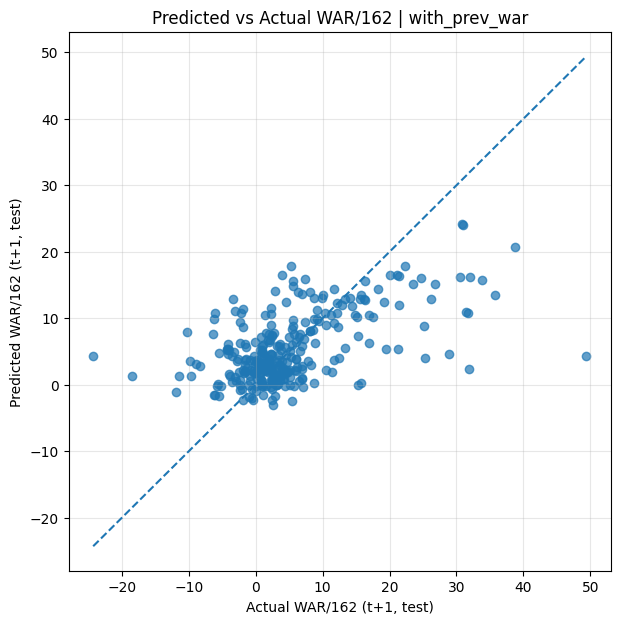

In [63]:
y_test = best_res['y_test']
y_pred = best_res['y_test_pred']

plt.figure()
plt.scatter(y_test, y_pred, alpha=0.7)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, linestyle='--')
plt.xlabel('Actual WAR/162 (t+1, test)')
plt.ylabel('Predicted WAR/162 (t+1, test)')
plt.title(f"Predicted vs Actual WAR/162 | {best_res['feature_mode']}")
plt.grid(True, alpha=0.3)
plt.show()


## 10. Save Best Model for Roster Optimizer

Save the best model (ElasticNet with `with_prev_war`) along with preprocessing objects.


In [64]:
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Use the best model from experiments (already trained with proper preprocessing)
best_feature_mode = best_res['feature_mode']
final_model = best_res['model']
imputer = best_res['imputer']
scaler = best_res['scaler']

# Save everything
model_artifacts = {
    'model': final_model,
    'imputer': imputer,
    'scaler': scaler,
    'feature_cols': best_res['feature_names'],
    'feature_mode': best_feature_mode,
    'min_ip': MIN_IP_TRAIN,
    'alpha': best_res['alpha'],  # Tuned alpha from CV
    'l1_ratio': best_res['l1_ratio'],  # Tuned l1_ratio from CV
}

joblib.dump(model_artifacts, 'models/pitcher_war_model_newest.joblib')
print(f"Saved pitcher WAR model to 'models/pitcher_war_model_newest.joblib'")
print(f"  Feature mode: {best_feature_mode}")
print(f"  Min IP (train): {MIN_IP_TRAIN}")
print(f"  Features: {len(best_res['feature_names'])}")
print(f"  Test R²: {best_res['test_r2']:.3f}")
print(f"  Tuned alpha: {best_res['alpha']:.4f}")
print(f"  Tuned l1_ratio: {best_res['l1_ratio']:.3f}")


Saved pitcher WAR model to 'models/pitcher_war_model_newest.joblib'
  Feature mode: with_prev_war
  Min IP (train): 30
  Features: 70
  Test R²: 0.316
  Tuned alpha: 0.1274
  Tuned l1_ratio: 0.500
